In [1]:
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

import torch
import torch.nn as nn

import time

# Interval is [0.5, 2.5]

In [4]:
class DeepliftingSimpleModel(nn.Module):
    def __init__(
        self,
    ):
        super(DeepliftingSimpleModel, self).__init__()

        # # One simple linear layer the input size will be 3
        # self.intermediate_linear_layer = nn.Linear(2, 2)

        self.linear_layer = nn.Linear(2, 1, bias=False)

        # # Simple input
        # self.x = nn.Parameter(torch.randn(1, 2))

    def get_linear_layer(self, inputs):
        return self.intermediate_linear_layer(inputs)

    def get_output_layer(self, inputs):
        output = self.linear_layer(inputs)
        return output

    def forward(self, inputs=None):
        if inputs is None:
            x = self.x
        else:
            x = inputs

        output = self.get_output_layer(x)

        # a & b are known for this example
        a, b = 0.5, 2.5
        return a + (b - a) / 2.0 * (torch.sin(output) + 1)
        return output


def objective(x):
    return torch.sin(10 * torch.pi * x) / (2 * x) + (x - 1) ** 4


def deeplifting_fn(x, model, objective, weights_list):
    """
    Combined funtion used for PyGranso
    """
    outputs = model(inputs=x)

    # Save the weights
    weights = [weights for name, weights in model.named_parameters()]
    weights_list.append(weights[0].detach().cpu().numpy())

    # Get x1 and x2 so we can add the bounds
    # outputs = torch.sigmoid(outputs)
    # x = outputs.mean(axis=0)
    # print(f'Output x {x}')
    f = objective(outputs)

    # Inequality constraint
    ci = None

    # Equality constraing
    ce = None

    return f, ci, ce

In [5]:
device = torch.device('cpu')

# Deeplifting model with skip connections
model = DeepliftingSimpleModel()
model = model.to(device=device, dtype=torch.double)

model.train()
nvar = getNvarTorch(model.parameters())

# Setup a pygransoStruct for the algorithm
# options
opts = pygransoStruct()

# Inital x0
x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 1
opts.limited_mem_size = 5
opts.stat_l2_model = False
opts.double_precision = True
opts.opt_tol = 1e-10
opts.maxit = 1000

x = torch.randn(1, 2)
x = x.to(device=device, dtype=torch.double)

# Set up the function with the results
# # Combined function
weights_list = []
comb_fn = lambda model: deeplifting_fn(
    x,
    model,
    objective,
    weights_list,
)  # noqa

# Run the main algorithm
start_time = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end_time = time.time()
total_time = end_time - start_time



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

In [6]:
input = x
input

tensor([[ 0.6128, -1.1904]], dtype=torch.float64)

In [7]:
import numpy as np

weights = np.vstack(weights_list)
x_min, x_max = np.round(weights[:, 0].min()) - 2.5, np.round(weights[:, 0].max()) + 2.5
y_min, y_max = np.round(weights[:, 1].min()) - 2.5, np.round(weights[:, 1].max()) + 2.5

(x_min, x_max, y_min, y_max)

(-10.5, 2.5, -2.5, 18.5)

In [8]:
x = torch.linspace(x_min, x_max, steps=1000)
y = torch.linspace(y_min, y_max, steps=1000)

x_flat = torch.meshgrid(x, y)[0].flatten()
y_flat = torch.meshgrid(x, y)[1].flatten()

weights = torch.stack((x_flat, y_flat)).T.to(device=device, dtype=torch.double)
weights

/Users/ryandevera/.virtualenvs/deeplifing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[-10.5000,  -2.5000],
        [-10.5000,  -2.4790],
        [-10.5000,  -2.4580],
        ...,
        [  2.5000,  18.4580],
        [  2.5000,  18.4790],
        [  2.5000,  18.5000]], dtype=torch.float64)

In [56]:
a, b = 0.5, 2.5
Z = objective(a + (b - a) / 2.0 * (torch.sin(input @ weights.T) + 1))
# Z = a + (b - a) / 2.0 * (torch.sin(input @ weights.T) + 1)
# Z = (input @ weights.T)

In [57]:
x = torch.linspace(x_min, x_max, steps=1000)
y = torch.linspace(y_min, y_max, steps=1000)

In [58]:
Z = Z.reshape(1000, 1000).detach().cpu().numpy()

In [59]:
X, Y = torch.meshgrid(x, y)
X = X.numpy()
Y = Y.numpy()

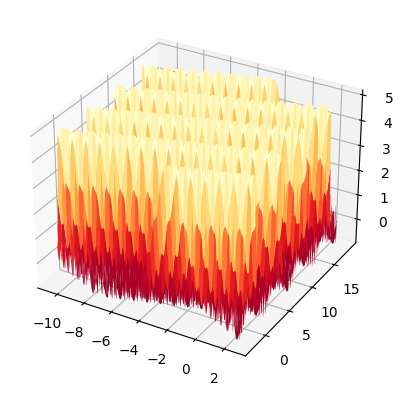

In [60]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a surface
ax.plot_surface(X, Y, Z, cmap='YlOrRd_r')

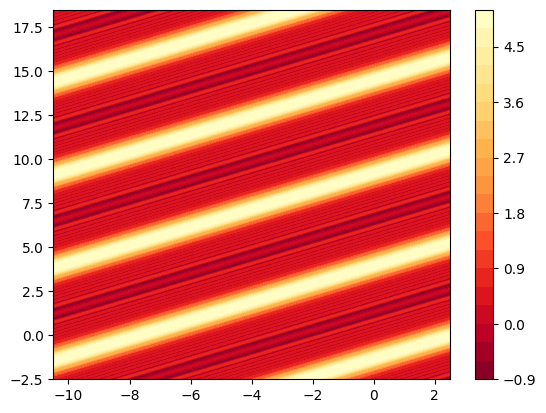

In [61]:
plt.figure()

# Create a contour plot
contour = plt.contourf(
    X, Y, Z, 20, cmap='YlOrRd_r'
)  # contourf fills the regions between contours
plt.colorbar(contour)  # Show a colorbar that maps color to Z values

In [47]:
model(inputs=input)

tensor([[0.5486]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [48]:
[i for i in model.named_parameters()]

[('linear_layer.weight',
  Parameter containing:
  tensor([[-0.6735,  0.7099]], dtype=torch.float64, requires_grad=True))]

In [49]:
objective(model(inputs=input))

tensor([[-0.8690]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [50]:
%pwd
%cd ../..

/Users/ryandevera/data-science


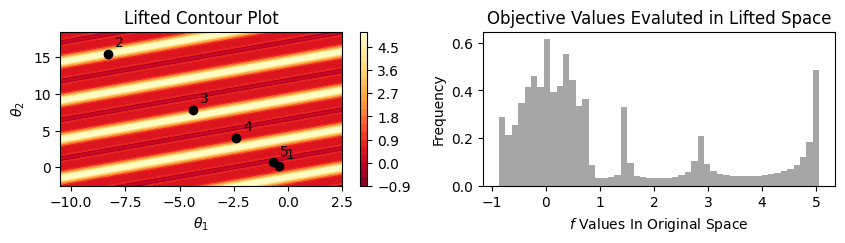

In [62]:
# Get the plot of the surface
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the layout
layout = """
    AB
"""

fig = plt.figure(figsize=(10, 2))
ax_dict = fig.subplot_mosaic(
    layout,
)

points = np.stack([points.flatten() for points in weights_list])
points = points[[0, 1, 2, 3, -1]]
x_values = points[:, 0]
y_values = points[:, 1]

# Contour plot
c = ax_dict['A'].contourf(X, Y, Z, 20, cmap='YlOrRd_r')
ax_dict['A'].scatter(x_values, y_values, color='black')

# for color_idx, (x, y) in enumerate(points):
for i in range(len(points)):
    x1, y1 = points[i]

    # Add the annotation
    ax_dict['A'].annotate(
        str(i + 1),
        xy=(x1, y1),
        xytext=(5, 5),
        textcoords='offset points',
        color='black',
    )
# divider = make_axes_locatable(ax_dict['A'])
# cax = divider.append_axes("right", size="15%")
# fig.colorbar(c, cax=cax, orientation='horizontal')
fig.colorbar(c, orientation='vertical')
# ax_dict['A'].axis('off')
ax_dict['A'].set_title('Lifted Contour Plot')
ax_dict['A'].set_xlabel('$ \\theta _1$')
ax_dict['A'].set_ylabel('$ \\theta _2$')

# Histogram
ax_dict['B'].hist(Z.ravel(), bins=50, color='grey', alpha=0.7, density=True)
ax_dict['B'].set_title('Objective Values Evaluted in Lifted Space')
ax_dict['B'].set_xlabel('$f$ Values In Original Space')
ax_dict['B'].set_ylabel('Frequency')

# z = torch.tensor(Z.ravel())
# f = objective(z).cpu().numpy()

# ax_dict['C'].scatter(z, f)
# ax_dict['C'].set_title('Gramacy and Lee Function')

plt.subplots_adjust(hspace=0.6)

# # fig.tight_layout()
# fig.savefig(
#     './images/deeplifting_proof_of_concept_v3.png', bbox_inches='tight', pad_inches=0.04
# )

In [29]:
points[[0, 1, 2, 3, -1]]

array([[-0.42725945,  0.23170137],
       [-8.29627667, 15.5171115 ],
       [-4.36176806,  7.87440644],
       [-2.39451375,  4.05305391],
       [-0.67345813,  0.70993744]])